In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
import lightgbm as lgb
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
import time

SEED = 50

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


In [3]:
dt_train = pd.read_csv("../input/train.csv")
print("Number of Training Examples = {}" .format(dt_train.shape))

Number of Training Examples = (200000, 202)


In [5]:
dt_test = pd.read_csv("../input/test.csv")
print("Number of Test Examples = {}" .format(dt_test.shape))

Number of Test Examples = (200000, 201)


In [6]:
#Here we print in the columns on our TRAIN and TEST Datasets
print(dt_train.columns)
print(dt_test.columns)

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)
Index(['ID_code', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5',
       'var_6', 'var_7', 'var_8',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=201)


In [7]:
#We use the .info to check informations about our dataset and then the .head to get 5 details from our train data  
print(dt_train.info())
dt_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB
None


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [9]:
#We use the .info to check informations about our dataset and then the .head to get 5 details from our test data 
print(dt_test.info())
dt_test.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, ID_code to var_199
dtypes: float64(200), object(1)
memory usage: 306.7+ MB
None


,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [10]:
#we check for numeric missing values
dt_train.name = "Training Dataset"
dt_test.name = "Test Dataset"
for dt in [dt_train, dt_test]:
    print('{} have {} missing values.'.format(dt.name, int(dt.isnull().values.any())))

Training Dataset have 0 missing values.
Test Dataset have 0 missing values.


In [11]:
#We checked to see how many percent of class 1 and 0 we have in our dataset (using the Target column)
ones = dt_train['target'].value_counts()[1]
zeros = dt_train['target'].value_counts()[0]
ones_per = ones / dt_train.shape[0] * 100
zeros_per = zeros / dt_train.shape[0] * 100

print('{} out of {} rows are Class 1 and it is the {:.2f}% of the dataset.'.format(ones, dt_train.shape[0], ones_per))
print('{} out of {} rows are Class 0 and it is the {:.2f}% of the dataset.'.format(zeros, dt_train.shape[0], zeros_per))

20098 out of 200000 rows are Class 1 and it is the 10.05% of the dataset.
179902 out of 200000 rows are Class 0 and it is the 89.95% of the dataset.


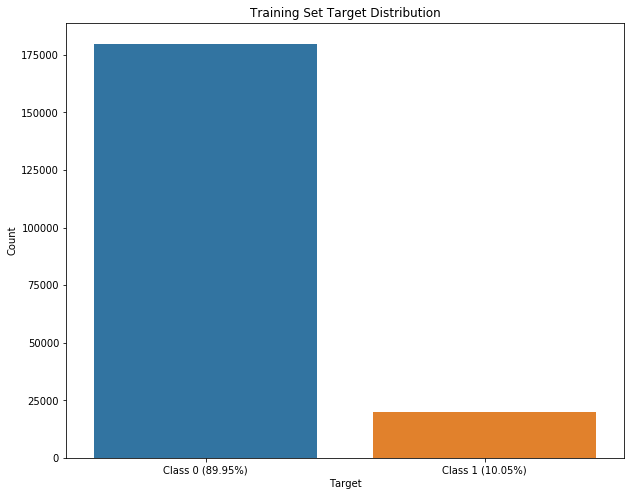

In [12]:
#we plot a graph to show or visual the percentage of each class showing who has the largest and the lowest
plt.figure(figsize=(10, 8))
sns.countplot(dt_train['target'])

plt.xlabel('Target')
plt.xticks((0, 1), ['Class 0 ({0:.2f}%)'.format(zeros_per), 'Class 1 ({0:.2f}%)'.format(ones_per)])
plt.ylabel('Count')
plt.title('Training Set Target Distribution')

plt.show()

In [13]:
#we try to see how many uniques values are there in each column on our train and test datasets
dt_train_unique = dt_train.agg(['nunique']).transpose().sort_values(by='nunique')
dt_test_unique = dt_test.agg(['nunique']).transpose().sort_values(by='nunique')
dt_uniques = dt_train_unique.drop('target').reset_index().merge(dt_test_unique.reset_index(), how='right', right_index=True, left_index=True)
print(dt_uniques.head())


   index_x  nunique_x  index_y  nunique_y
0   var_68        451   var_68        428
1   var_91       7962   var_91       7569
2  var_108       8525  var_108       8188
3  var_103       9376  var_103       8828
4   var_12       9561   var_12       9121


In [14]:
#since both the x and y index are both showing same columns above, we had to delete one for easy reading
dt_uniques.drop(columns=['index_y'], inplace=True)
dt_uniques.columns = ['Feature', 'Training Set Unique Count', 'Test Set Unique Count']
print(dt_uniques.head())

   Feature          ...            Test Set Unique Count
0   var_68          ...                              428
1   var_91          ...                             7569
2  var_108          ...                             8188
3  var_103          ...                             8828
4   var_12          ...                             9121

[5 rows x 3 columns]


/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


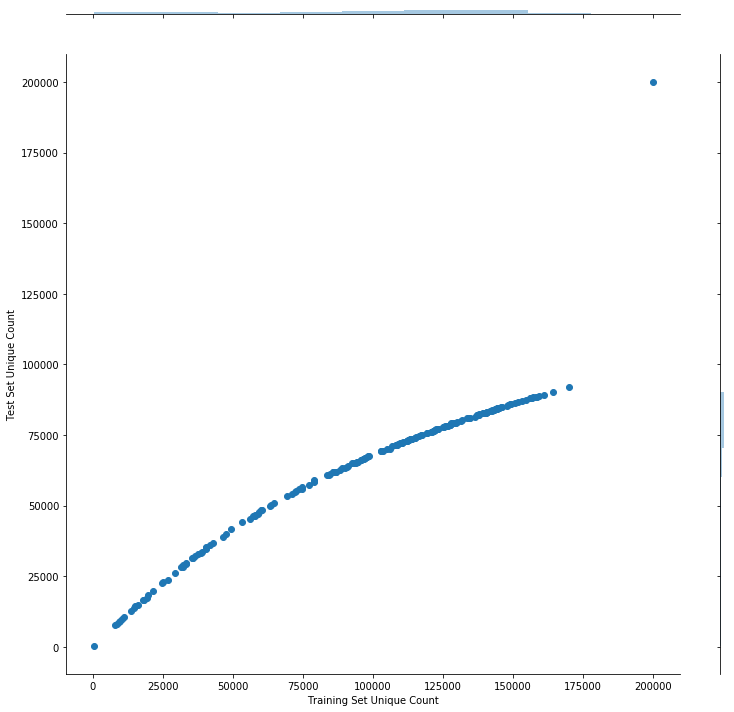

In [15]:
#we plot a joint graph that shows that the train set has more unique values than the test set
sns.jointplot(x='Training Set Unique Count', y='Test Set Unique Count', data=dt_uniques, size=10, space=10, ratio=15, kind="scatter")
sns.set(style="darkgrid")

In [16]:
#features = [c for e in dt_train.columns if c not in ['ID_code', 'target']
cols=["target","ID_code"]
X = dt_train.drop(cols, axis=1)
y = dt_train.target

In [17]:
params = {'objective': "binary",
          'boost': "gbdt",
          'boost_from_average': "false",
          'num_threads': 8,
          'learning rate': 0.001,
          'num_leaves': 4,
          'max_depth': 8,
          'tree_learner': "serial",
          'feature_fraction': 0.05,
          'bagging_fraq': 1.0,
          'bagging_fraction': 0.4,
          'min_data_in_leaf': 80,
          'verbosity': 1,
          'metric': 'auc',
          'sigmoid':1.0,
          'lambda_l1':0.01,
          'snapshot_freq':1
}

In [18]:
folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=10)
length_train = np.zeros(len(dt_train))
dt_predictions = np.zeros(len(dt_test))
important_dt = pd.DataFrame()

In [19]:
for fold_n, (train_index, valid_index) in enumerate (folds.split(X, y)):
    print("folds {}," "fold_n {}," "started at {}".format(folds, fold_n, time.ctime()))
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    lgb_model = lgb.train(params, train_data, num_boost_round=2000,
                         valid_sets = [train_data, valid_data], verbose_eval=1000,
                         early_stopping_rounds = 2500, )
    
    length_train[valid_index] = lgb_model.predict(X_valid, num_iteration=lgb_model.best_iteration) 
    

    
    

folds StratifiedKFold(n_splits=5, random_state=10, shuffle=False),fold_n 0,started at Tue Jun  4 03:41:11 2019
Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.913749	valid_1's auc: 0.892271
[2000]	training's auc: 0.9261	valid_1's auc: 0.896759
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.9261	valid_1's auc: 0.896759
folds StratifiedKFold(n_splits=5, random_state=10, shuffle=False),fold_n 1,started at Tue Jun  4 03:42:09 2019
Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.914319	valid_1's auc: 0.891215
[2000]	training's auc: 0.926556	valid_1's auc: 0.894785
Did not meet early stopping. Best iteration is:
[2000]	training's auc: 0.926556	valid_1's auc: 0.894785
folds StratifiedKFold(n_splits=5, random_state=10, shuffle=False),fold_n 2,started at Tue Jun  4 03:43:03 2019
Training until validation scores don't improve for 2500 rounds.
[1000]	training's auc: 0.913251	valid_1's auc: 

In [20]:
dt_tes = dt_test.drop(['ID_code'], axis=1)
print(dt_tes.head())

     var_0    var_1    var_2   ...     var_197  var_198  var_199
0  11.0656   7.7798  12.9536   ...     10.7200  15.4722  -8.7197
1   8.5304   1.2543  11.3047   ...      9.8714  19.1293 -20.9760
2   5.4827 -10.3581  10.1407   ...      7.0618  19.8956 -23.1794
3   8.5374  -1.3222  12.0220   ...      9.2295  13.0168  -4.2108
4  11.7058  -0.1327  14.1295   ...      7.2882  13.9260  -9.1846

[5 rows x 200 columns]


In [21]:
    dt_predictions += lgb_model.predict(dt_tes, num_iteration = lgb_model.best_iteration)/folds.n_splits
    
print("CV Score: {:<8.5f}".format(roc_auc_score(y, length_train)))

CV Score: 0.89789 


In [22]:
dt_predictio = pd.DataFrame(dt_predictions)

In [23]:
submit = pd.DataFrame({"ID_code": dt_test["ID_code"].values})
submit["target"] = dt_predictio
submit.to_csv("submit.csv", index=False)

In [24]:
new = pd.read_csv("submit.csv")

In [25]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
ID_code    200000 non-null object
target     200000 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.1+ MB
